In [40]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

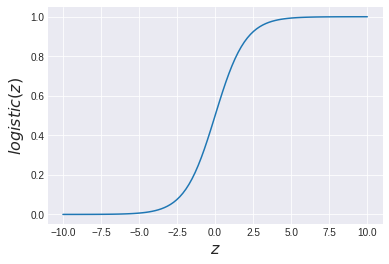

In [41]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$logistic(z)$', fontsize=16)
plt.savefig('B04958_05_01.png', dpi=300, figsize=(5.5, 5.5))

In [42]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


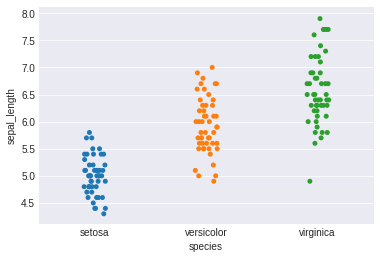

In [43]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B04958_05_03.png', dpi=300, figsize=(5.5, 5.5))

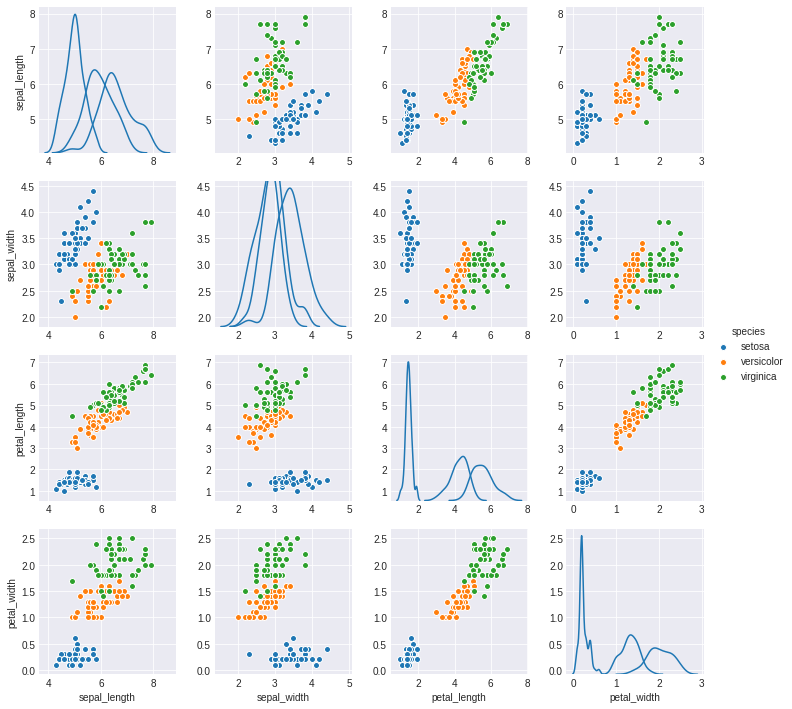

In [44]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B04958_05_04.png', dpi=300, figsize=(5.5, 5.5))

In [45]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [46]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    trace_0 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:19<00:00, 286.94it/s]
The number of effective samples is smaller than 25% for some parameters.


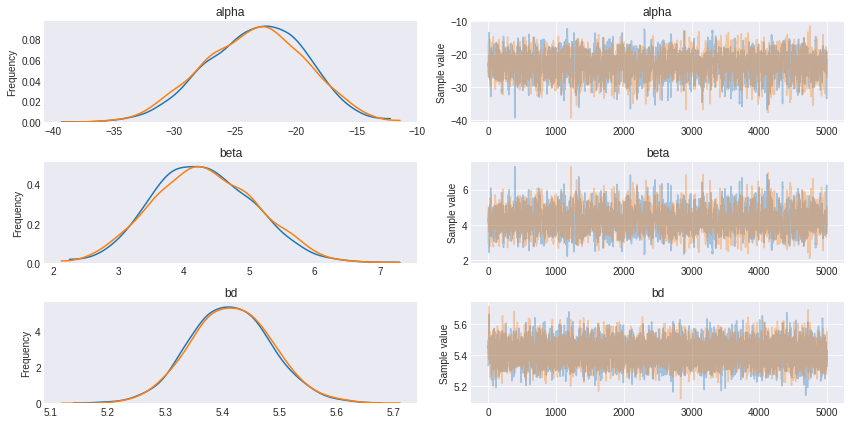

In [47]:
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(trace_0, varnames)
plt.savefig('B04958_05_05.png', dpi=300, figsize=(5.5, 5.5))

In [48]:
#pm.autocorrplot(trace_0, varnames);

In [49]:
#sns.kdeplot(trace_0['alpha'], cadena_0['beta']);

In [50]:
pm.summary(trace_0, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.36,4.14,1.17e-01,-31.42,-15.69,1254.0,1.0
beta,4.31,0.77,2.18e-02,2.86,5.78,1247.0,1.0
bd,5.42,0.07,7.22e-04,5.28,5.56,8701.0,1.0


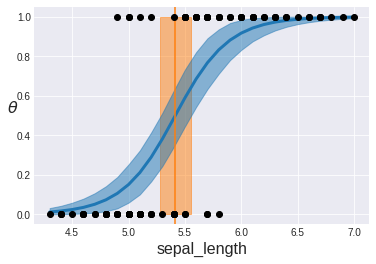

In [51]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='C0', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='C1')
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='C0', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_05_06.png', dpi=300, figsize=(5.5, 5.5))

In [52]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([ 0.14,  0.59,  0.93]), array([False,  True,  True], dtype=bool))

## Multiple logistic regression

In [53]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0)) / x_1.std(axis=0)
#x_1 = (x_1 - x_1.mean(axis=0))

In [54]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Aplly the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    # Sampling
    trace_1 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:27<00:00, 197.16it/s]


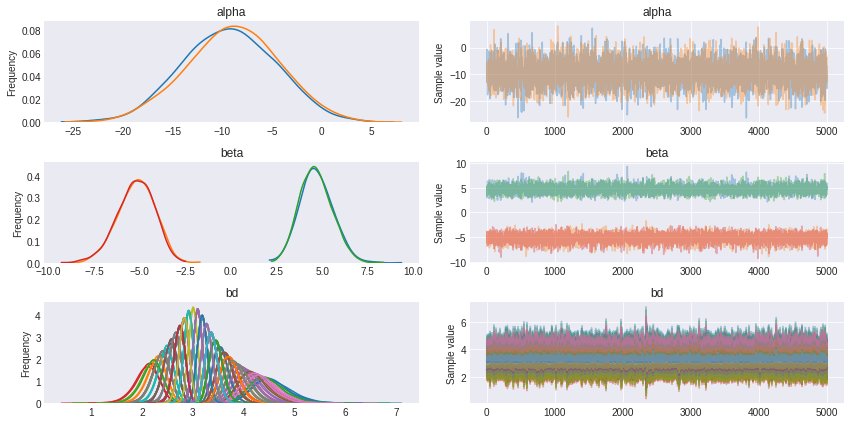

In [55]:
pm.traceplot(trace_1)
plt.savefig('B04958_05_07.png', dpi=300, figsize=(5.5, 5.5))

In [56]:
#pm.df_summary(chain_1, ['alpha', 'beta'])

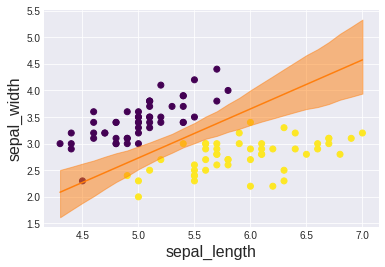

In [57]:
idx = np.argsort(x_1[:,0])
ld = trace_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0, cmap='viridis')
plt.plot(x_1[:,0][idx], ld, color='C1');

ld_hpd = pm.hpd(trace_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0],
                 ld_hpd[:,1], color='C1', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_08.png', dpi=300, figsize=(5.5, 5.5))

## Correlated variables

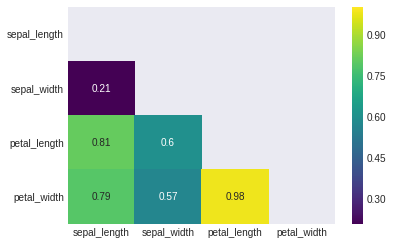

In [58]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.savefig('B04958_05_09.png', dpi=300, figsize=(5.5, 5.5))

## Unbalanced Classes

In [59]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
#plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [60]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic link function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:23<00:00, 233.53it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.881834286294, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


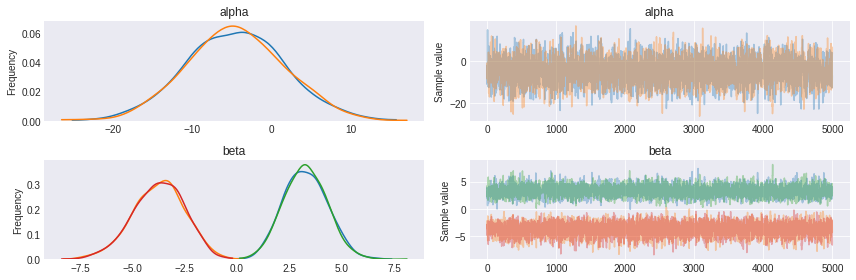

In [61]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.traceplot(cadena_3, varnames);

In [62]:
pm.summary(cadena_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-4.52,6.16,0.10,-16.06,8.10,2807.0,1.0
beta__0,3.28,1.03,0.02,1.29,5.24,2955.0,1.0
beta__1,-3.74,1.23,0.02,-6.17,-1.39,3332.0,1.0


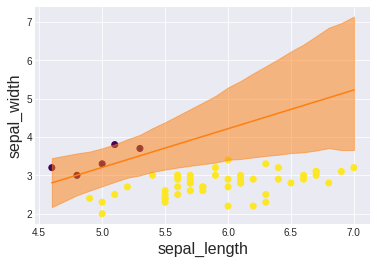

In [63]:
idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c=y_3, cmap='viridis')
plt.plot(x_3[:,0][idx], ld, color='C1');

ld_hpd = pm.hpd(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='C1', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_10.png', dpi=300, figsize=(5.5, 5.5))

## Softmax logistic regression (AKA multinomial regression)

In [64]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [65]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 2500/2500 [00:18<00:00, 136.56it/s]
The acceptance probability does not match the target. It is 0.878836275487, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889472941138, but should be close to 0.8. Try to increase the number of tuning steps.


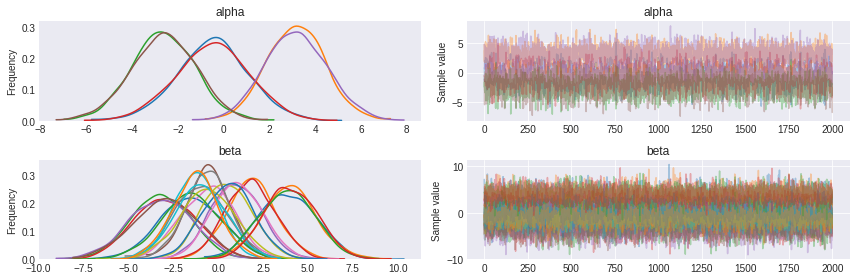

In [66]:
pm.traceplot(trace_s)
plt.savefig('B04958_05_12.png', dpi=300, figsize=(5.5, 5.5))

In [67]:
pm.summary(trace_s)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-0.50,1.56,0.02,-3.53,2.57,4000.0,1.0
alpha__1,3.14,1.31,0.02,0.64,5.76,3302.0,1.0
alpha__2,-2.65,1.39,0.03,-5.36,0.10,3441.0,1.0
beta__0_0,-1.54,1.69,0.02,-4.83,1.77,4000.0,1.0
beta__0_1,1.00,1.39,0.02,-1.55,3.88,2988.0,1.0
beta__0_2,0.49,1.39,0.02,-2.05,3.29,3497.0,1.0
beta__1_0,1.80,1.37,0.03,-0.98,4.41,3445.0,1.0
beta__1_1,-0.57,1.23,0.02,-3.13,1.78,2922.0,1.0
beta__1_2,-1.27,1.26,0.02,-3.72,1.27,3054.0,1.0
beta__2_0,-3.23,1.72,0.02,-6.49,0.18,4000.0,1.0


In [68]:
#pm.autocorrplot(trace_s, varnames=['alpha']);

In [69]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)

0.97333333333333338

In [70]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace_sf = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 2500/2500 [00:16<00:00, 152.27it/s]


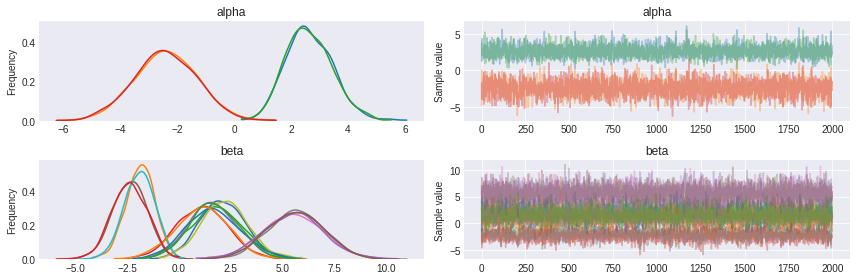

In [71]:
pm.traceplot(trace_sf)
plt.savefig('B04958_05_13.png', dpi=300, figsize=(5.5, 5.5))

In [72]:
pm.summary(trace_sf)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.63,0.81,0.02,1.17,4.29,2653.0,1.0
alpha__1,-2.42,1.09,0.02,-4.60,-0.33,2914.0,1.0
beta__0_0,2.15,1.13,0.02,-0.16,4.31,2455.0,1.0
beta__0_1,1.67,1.17,0.02,-0.57,4.02,2642.0,1.0
beta__1_0,-1.90,0.71,0.01,-3.28,-0.51,2468.0,1.0
beta__1_1,-2.40,0.84,0.01,-3.97,-0.80,2660.0,1.0
beta__2_0,1.72,1.29,0.03,-0.76,4.31,2256.0,1.0
beta__2_1,5.50,1.46,0.03,2.62,8.38,3235.0,1.0
beta__3_0,1.11,1.26,0.03,-1.43,3.53,2347.0,1.0
beta__3_1,5.64,1.37,0.03,3.07,8.37,2586.0,1.0


## Linear discriminat Analysis

In [73]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [74]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0] + mus[1]) / 2)

    trace_lda = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, mus]
100%|██████████| 5500/5500 [00:04<00:00, 1372.32it/s]


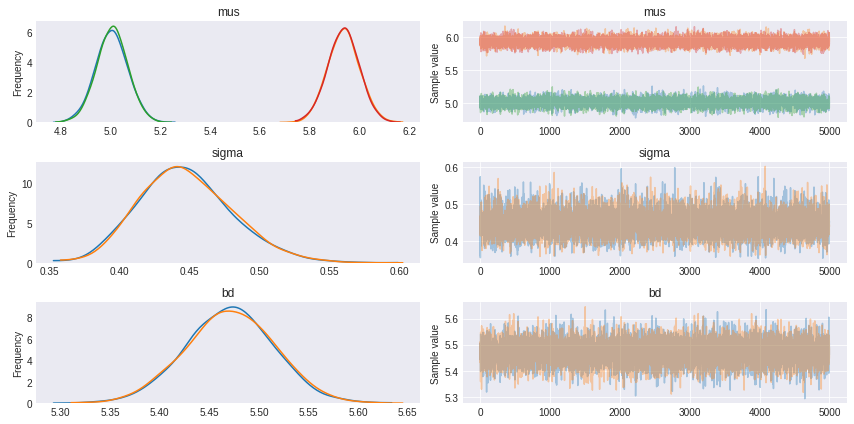

In [75]:
pm.traceplot(trace_lda)
plt.savefig('B04958_05_14.png', dpi=300, figsize=(5.5, 5.5))

In [76]:
pm.summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,5.01,0.06,5.85e-04,4.88,5.13,10000.0,1.0
mus__1,5.94,0.06,5.02e-04,5.81,6.06,10000.0,1.0
sigma,0.45,0.03,3.05e-04,0.39,0.51,10000.0,1.0
bd,5.47,0.04,3.84e-04,5.38,5.55,10000.0,1.0


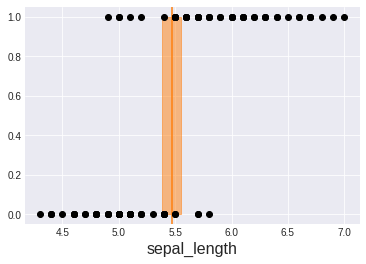

In [77]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

plt.xlabel(x_n, fontsize=16)
plt.savefig('B04958_05_15.png', dpi=300, figsize=(5.5, 5.5))

In [78]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.6.3
IPython 6.1.0
PyMC3 3.3
NumPy 1.13.3
SciPy 1.0.0
Matplotlib 2.1.0
Seaborn 0.8.0
Pandas 0.20.3
